**Import the required libraries**

In [1]:
import time
import math
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import progressbar
import cv2
from sklearn.preprocessing import MinMaxScaler
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**Making the results reproducible (knowing the random seed of the two libraries)**

In [2]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 97
tf_rand_seed = 82
np.random.seed(np_rand_seed)
# print("numpy random seed: ",np_rand_seed)
# print("tensorflow random seed: ", tf_rand_seed)

# **1. Load and Inspect the data**

In [3]:
data = pd.read_json('../input/train.json')
test_data = pd.read_json('../input/test.json')

In [4]:
data.head(5)

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [5]:
test_data.head(5)

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [6]:
print("Shape of train set:", data.shape)
print("Shape of test set:", test_data.shape)

Shape of train set: (1604, 5)
Shape of test set: (8424, 4)


In [7]:
print("Shape of band 1:",  np.shape(data.band_1.iloc[0]))
print("Shape of band 2:",  np.shape(data.band_2.iloc[0]))

Shape of band 1: (5625,)
Shape of band 2: (5625,)


In [8]:
print("Type of band 1:",  type(data.band_1.iloc[0]))
print("Type of band 2:",  type(data.band_2.iloc[0]))

Type of band 1: <class 'list'>
Type of band 2: <class 'list'>


# **2. Feature Engineering**

## **2.1 Feature engineering on train set**

### **2.1.1 Replacing the na in inc_anlge with mean**********

In [9]:
data[data['inc_angle']=='na'] = data[data['inc_angle']!='na']['inc_angle'].mean()

### **2.1.2 Converting the angle from degrees to radian******

In [10]:
data['inc_angle'] = data['inc_angle'].apply(lambda x: math.radians(x))

In [11]:
data.inc_angle.head()

0    0.766617
1    0.665951
2    0.790388
3    0.764988
4    0.621784
Name: inc_angle, dtype: float64

### 2.1.3 Finding and droping points with mismatch band1 and band2 data

**Function which return the count and the index of mismatched data**

In [12]:
def find_missing_data(series, shape):
    
    '''function which return the count and the index of mismatched data'''    
    count = 0
    missing_list = []
    for i,x in enumerate(series):   
        if np.shape(series.iloc[i]) != shape:
            missing_list.append(i)
            count += 1
            
    return missing_list, count


**Count and list of mismatched points in band1**

In [13]:
missing_list1, count1 = find_missing_data(data.band_1, (5625,))
print("count: ", count1)
print("missing data: ", missing_list1)

count:  133
missing data:  [101, 126, 142, 145, 176, 179, 191, 278, 286, 342, 412, 431, 440, 493, 642, 666, 667, 730, 741, 742, 763, 822, 863, 868, 906, 916, 996, 1041, 1065, 1095, 1199, 1228, 1247, 1257, 1268, 1290, 1345, 1403, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603]


**Count and list of mismatched points in band2**

In [14]:
missing_list2, count2 = find_missing_data(data.band_2, (5625,))
print("count: ", count1)
print("missing data: ", missing_list2)

count:  133
missing data:  [101, 126, 142, 145, 176, 179, 191, 278, 286, 342, 412, 431, 440, 493, 642, 666, 667, 730, 741, 742, 763, 822, 863, 868, 906, 916, 996, 1041, 1065, 1095, 1199, 1228, 1247, 1257, 1268, 1290, 1345, 1403, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603]


**Check if the missing points are same**

In [15]:
missing_list1 == missing_list2

True

**Function to drop data by index**

In [16]:
def drop_data(df, index):
    
    '''function to drop data by index'''
    return df.drop(df.index[index])

**Drop the points with mismatched images**

In [17]:
data = drop_data(data, missing_list1)

In [18]:
data.shape

(1471, 5)

In [19]:
print("Number of positive classes: ", len(data[data['is_iceberg'] == 1.0]))
print("Number of negative classes: ", len(data[data['is_iceberg'] == 0.0]))

Number of positive classes:  753
Number of negative classes:  718


### 2.1.4 Scale the image data


**3 standardization to technique we can try on**

In [20]:
def max_finder(data):
    maximum = 0
    current_maximum = None
    for band in data: 
        current_maximum = np.max(band)
        if current_maximum>maximum:
            maximum = current_maximum
    return maximum

In [21]:
def min_finder(data):
    minimum = 0
    current_minimum = None
    for band in data: 
        current_minimum = np.min(band)
        if current_minimum<minimum:
            minimum = current_minimum
    return minimum

In [22]:
band_1_max = max_finder(data['band_1'])
band_2_max = max_finder(data['band_2'])
band_1_min = min_finder(data['band_1'])
band_2_min = min_finder(data['band_2'])

In [23]:
print("band 1 max:",band_1_max)
print("band 2 max:",band_2_max)
print("band 1 min:",band_1_min)
print("band 2 min:",band_2_min)

band 1 max: 34.574917
band 2 max: 20.154249
band 1 min: -45.594448
band 2 min: -45.655499


In [24]:
def standardise_vector(vector):
    '''standardise vector'''
    standardised_vector = (np.array(vector) - np.mean(vector)) / np.std(vector)
    return standardised_vector.tolist()

In [25]:
def mean_normalise_vector(vector):
    '''mean normalize vector'''
    normalised_vector = (np.array(vector) - np.mean(vector)) / (np.max(vector) - np.min(vector))
    return normalised_vector.tolist()

In [26]:
def min_max_scaler(vector, minimum, maximum, global_min, global_max):
    '''minmaxscaler'''
    X_std  = (np.array(vector) - global_min) / (global_max - global_min)
    scaled_vector = X_std * (maximum - minimum) + minimum
    return scaled_vector.tolist()

**We will use minmaxscaler as the  normalization technique since this works well with images**

In [27]:
data['band_1'] = data['band_1'].apply(min_max_scaler, args = (-1,1,band_1_min,band_1_max))
data['band_2'] = data['band_2'].apply(min_max_scaler, args = (-1,1,band_2_min,band_2_max))

In [28]:
data.head(5)

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-0.5580334957124831, -0.5399667192075177, -0....","[-0.43773129172292236, -0.5101755745972466, -0...",dfd5f913,0.766617,0.0
1,"[-0.16795965640990163, -0.23476647220543656, -...","[-0.5699975024976542, -0.46296876869973735, -0...",e25388fd,0.665951,0.0
2,"[-0.4763393223833069, -0.4763402703763464, -0....","[-0.3683445498074237, -0.3446907895772523, -0....",58b2aaa0,0.790388,1.0
3,"[-0.42272609992607524, -0.43839822106611426, -...","[-0.46007761646496503, -0.448844417395429, -0....",4cfc3a18,0.764988,0.0
4,"[-0.511347208500404, -0.4404455617179954, -0.4...","[-0.43933582605421917, -0.5320962785026924, -0...",271f93f4,0.621784,0.0


### **2.1.5 Reshaping the band1 and band2 data into 2D image**

In [29]:
band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_1"]])
band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_2"]])

In [30]:
print("Shape of band 1 image:",band_1.shape)
print("Shape of band 2 image:",band_2.shape)

Shape of band 1 image: (1471, 75, 75)
Shape of band 2 image: (1471, 75, 75)


## **2.2 Feature engieering on test Set**

**We carry out the same feature engineering as carried out on train set**

In [31]:
test_data['inc_angle'] = test_data['inc_angle'].apply(lambda x: math.radians(x))

In [32]:
test_data.inc_angle.head()

0    0.610279
1    0.569240
2    0.654593
3    0.601683
4    0.766529
Name: inc_angle, dtype: float64

In [33]:
missing_list3, count3 = find_missing_data(test_data.band_1, (5625,))
print("count: ", count3)
print("missing data: ", missing_list3)

count:  0
missing data:  []


In [34]:
missing_list4, count4 = find_missing_data(test_data.band_2, (5625,))
print("count: ", count4)
print("missing data: ", missing_list4)

count:  0
missing data:  []


In [35]:
test_data['band_1'] = test_data['band_1'].apply(standardise_vector)
test_data['band_2'] = test_data['band_2'].apply(standardise_vector)

In [36]:
band_1_test = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test_data["band_1"]])
band_2_test = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test_data["band_2"]])

In [37]:
print("Shape of test set band 1 image:",band_1_test.shape)
print("Shape of test set band 2 image:",band_2_test.shape)

Shape of test set band 1 image: (8424, 75, 75)
Shape of test set band 2 image: (8424, 75, 75)


# **3. Train/test/validation split**

**Extract the labels and angles of train set**

In [38]:
labels = data.is_iceberg.values
angles = data.inc_angle.values

**Carry out splits**

In [39]:
# randomly choosing the train and validation indices
train_indices = np.random.choice(len(labels), round(len(labels)*0.75), replace=False)
validation_indices = np.array(list(set(range(len(labels))) - set(train_indices)))

# extract train set
band_1_train = band_1[train_indices]
band_2_train = band_2[train_indices]
angles_train = angles[train_indices]
labels_train = labels[train_indices]

# extract validation set
band_1_validation = band_1[validation_indices]
band_2_validation = band_2[validation_indices]
angles_validation = angles[validation_indices]
labels_validation = labels[validation_indices]

# extract test set
band_1_test = band_1_test
band_2_test = band_2_test
angles_test = test_data.inc_angle.values
test_ids = test_data.id.values

**Covert the types of all data to float**

In [40]:
band_1_train = band_1_train.astype(np.float32)
band_1_validation = band_1_validation.astype(np.float32)
band_1_test = band_1_test.astype(np.float32)
band_2_train = band_2_train.astype(np.float32)
band_2_validation = band_2_validation.astype(np.float32)
band_2_test = band_2_test.astype(np.float32)
angles_train = angles_train.astype(np.float32)
angles_validation = angles_validation.astype(np.float32)
angles_test = angles_test.astype(np.float32)
labels_train = labels_train.astype(np.float32)
labels_validation = labels_validation.astype(np.float32)
test_ids = test_ids.astype(np.str)

In [41]:
# delete the unnecessary variables out of memory
del(data, test_data, band_1, band_2)

**Examine the shape of the data**

In [42]:
print("Shape of band_1_train:",band_1_train.shape)
print("Shape of band_2_train:",band_1_train.shape)
print("Shape of angles_train:",angles_train.shape)
print("Shape of labels_train:",labels_train.shape)
print("Shape of band_1_validation:",band_1_validation.shape)
print("Shape of band_2_validation:",band_2_validation.shape)
print("Shape of angles_validation:",angles_validation.shape)
print("Shape of labels_validation:",labels_validation.shape)
print("Shape of band_1_test:",band_1_test.shape)
print("Shape of band_2_test:",band_2_test.shape)
print("Shape of angles_test:",angles_test.shape)
print("Shape of iD:",test_ids.shape)

Shape of band_1_train: (1103, 75, 75)
Shape of band_2_train: (1103, 75, 75)
Shape of angles_train: (1103,)
Shape of labels_train: (1103,)
Shape of band_1_validation: (368, 75, 75)
Shape of band_2_validation: (368, 75, 75)
Shape of angles_validation: (368,)
Shape of labels_validation: (368,)
Shape of band_1_test: (8424, 75, 75)
Shape of band_2_test: (8424, 75, 75)
Shape of angles_test: (8424,)
Shape of iD: (8424,)


# **4. Augmenting train set**

## **4.1 Functions to carry out different augmentation technique**

**4.1.1 Image Rotation**

In [43]:
def rotate_image(img, angle = 20):
    
    '''a function to rotate image by a given degree'''
    
    # rotate image
    original = img.copy()

    M_rotate = cv2.getRotationMatrix2D((37,37),angle,1)
    img_new = cv2.warpAffine(img,M_rotate,(75,75))
    
    length_row = 0
    length_column = 0
    boundary_step = 5
    
    for i in range(len(img_new)):
        if img_new[0,i]!=float(0.0):
            length_row = i
            break
    for i in range(len(img_new)):
        if img_new[i,0]!=float(0.0):
            length_column = i
            break
    
    # subsitute the padding from original image
    img_new[:length_column+boundary_step,:length_row+boundary_step] = \
    original[:length_column+boundary_step,:length_row+boundary_step] 
    img_new[-(length_row+boundary_step):,:length_column+boundary_step] = \
    original[-(length_row+boundary_step):,:length_column+boundary_step]
    img_new[:length_row+boundary_step,-(length_column+boundary_step):] = \
    original[:length_row+boundary_step,-(length_column+boundary_step):]
    img_new[-(length_column+boundary_step):,-(length_row+boundary_step):] = \
    original[-(length_column+boundary_step):,-(length_row+boundary_step):]
    
    return img_new

**4.1.2 Horizontal translation**

In [44]:
def translate_horizontal(image, shift_horizontal = 5):
    
    '''a function to translate image horizontally by a shift'''
    
    # horizontally shift image
    img = image.copy()
    
    shift_vertical = 0; 
    if shift_horizontal<0:
        image_slice = img[:,shift_horizontal:].copy()
    if shift_horizontal>0:
        image_slice = img[:,:shift_horizontal].copy()
    M_translate = np.float32([[1,0,shift_horizontal],[0,1,shift_vertical]])
    img_new = cv2.warpAffine(img,M_translate,(75,75))
    
    # subsitute the padding from original image
    if shift_horizontal<0:
        img_new[:,shift_horizontal:] = image_slice
    if shift_horizontal>0:
        img_new[:,:shift_horizontal] = image_slice
        
    return img_new.reshape(75,75).astype(np.float32)

**4.1.3 Vertical translation**

In [45]:
def translate_vertical(image, shift_vertical = 5):
    
    '''a function to translate image vertically by a shift'''
    
    # vertically shift image
    img = image.copy()
    
    shift_horizontal = 0;
    if shift_vertical<0:
        image_slice = img[shift_vertical:,:].copy()
    if shift_vertical>0:
        image_slice = img[:shift_vertical,:].copy()
    M_translate = np.float32([[1,0,shift_horizontal],[0,1,shift_vertical]])
    img_new = cv2.warpAffine(img,M_translate,(75,75))
    
    # subsitute the padding from original image
    if shift_vertical<0:
        img_new[shift_vertical:,:] = image_slice
    if shift_vertical>0:
        img_new[:shift_vertical,:] = image_slice
        
    return img_new.reshape(75,75).astype(np.float32)

**4.1.4 Translation along positive diagonal**

In [46]:
def translate_positive_diagonal(image, shift_diagonal = 5):
    
    '''a function to translate image along positive diagonal'''
    
    # translate image along positive diagonal
    img = image.copy()
    
    if shift_diagonal<0:
        hor_slice = img[shift_diagonal:,:].copy()
        ver_slice = img[:,shift_diagonal:].copy()
    else:
        hor_slice = img[:shift_diagonal,:].copy()
        ver_slice = img[:,:shift_diagonal].copy()
    M_translate = np.float32([[1,0,shift_diagonal],[0,1,shift_diagonal]])
    img_new = cv2.warpAffine(img,M_translate,(75,75))
    
    # subsitute the padding from original image
    if shift_diagonal<0:
        img_new[shift_diagonal:,:] = hor_slice
        img_new[:,shift_diagonal:] = ver_slice
    else:
        img_new[:shift_diagonal,:] = hor_slice
        img_new[:,:shift_diagonal] = ver_slice
    
    return img_new.reshape(75,75).astype(np.float32)

**4.1.5 Translation along negative diagonal**

In [47]:
def translate_negative_diagonal(image, shift_diagonal = 5):
    
    '''a function to translate image along negative diagonal'''
    
    # translate image along negative diagonal
    img = image.copy()
    
    if shift_diagonal<0:
        hor_slice = img[:-shift_diagonal,:].copy()
        ver_slice = img[:,shift_diagonal:].copy()
    if shift_diagonal>0:
        hor_slice = img[-shift_diagonal:,:].copy()
        ver_slice = img[:,:shift_diagonal].copy()
    M_translate = np.float32([[1,0,shift_diagonal],[0,1,-shift_diagonal]])
    img_new = cv2.warpAffine(img,M_translate,(75,75))
    
    # subsitute the padding from original image
    if shift_diagonal<0:
        img_new[:-shift_diagonal,:] = hor_slice
        img_new[:,shift_diagonal:] = ver_slice
    if shift_diagonal>0:
        img_new[-shift_diagonal:,:] = hor_slice
        img_new[:,:shift_diagonal] = ver_slice
        
    return img_new.reshape(75,75).astype(np.float32)

**4.1.6 Flip Image**

In [48]:
def flip(image, direction = 0):
    
    '''a function to flip image'''
    img = image.copy()
    return cv2.flip(img,direction)

**4.1.7 Zoom image**

In [49]:
def zoom(image, zoom_shift = 5):
    
    '''a function to zoom image'''
    
    # zoom image
    img = image.copy()
    
    # zoom in 
    if zoom_shift>0:
        # scale
        img_new = cv2.resize(img, (75+zoom_shift*2,75+zoom_shift*2)) 
        # crop
        img_new = img_new[zoom_shift:-zoom_shift,zoom_shift:-zoom_shift] 
    # zoom out
    else:
        zoom_shift *=-1
        
        hor_top = img[:zoom_shift,:]
        hor_bottom =img[-zoom_shift:,:]
        ver_left = img[:,:zoom_shift]
        ver_right = img[:,-zoom_shift:]
        
        # scale
        img_new = cv2.resize(img, (75-zoom_shift*2,75-zoom_shift*2)) 
        # zero padding
        img_new = cv2.copyMakeBorder(img_new,zoom_shift,zoom_shift,zoom_shift,zoom_shift,
                                     cv2.BORDER_CONSTANT,value=0.0)
        # subsitute the padding from original image
        img_new[:zoom_shift,:] = hor_top
        img_new[-zoom_shift:,:] = hor_bottom
        img_new[:,:zoom_shift] = ver_left
        img_new[:,-zoom_shift:] = ver_right     
        
    return img_new.reshape(75,75).astype(np.float32)

## **4.2 Displaying augmented samples**

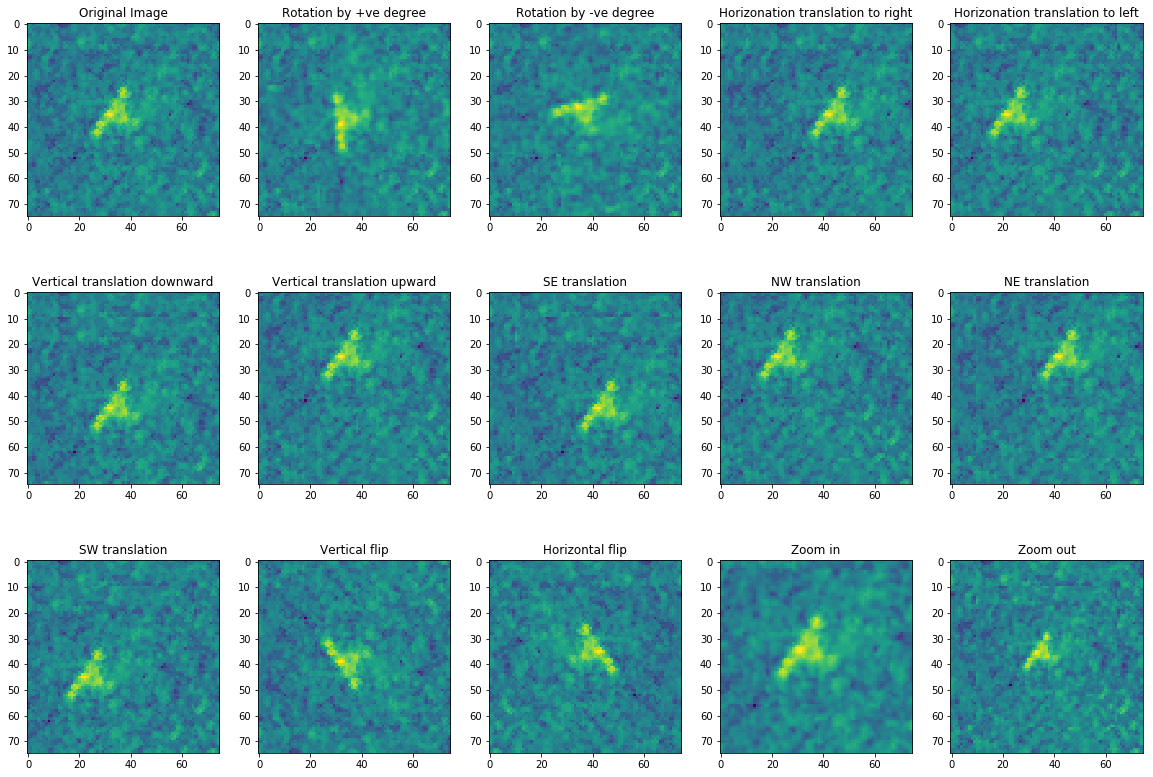

In [50]:
matplotlib.rcParams['figure.figsize'] = (20.0, 14.0)
image = band_1_test[3].copy()
plt.subplot(3, 5, 1)
plt.title("Original Image")
plt.imshow(image)
plt.subplot(3, 5, 2)
generated_image = rotate_image(image,40)
plt.title("Rotation by +ve degree")
plt.imshow(generated_image)
plt.subplot(3, 5, 3)
generated_image = rotate_image(image,-40)
plt.title("Rotation by -ve degree")
plt.imshow(generated_image)
plt.subplot(3, 5, 4)
generated_image = translate_horizontal(image,10)
plt.title("Horizonation translation to right")
plt.imshow(generated_image)
plt.subplot(3, 5, 5)
generated_image = translate_horizontal(image,-10)
plt.title("Horizonation translation to left")
plt.imshow(generated_image)
plt.subplot(3, 5, 6)
generated_image = translate_vertical(image,10)
plt.title("Vertical translation downward")
plt.imshow(generated_image)
plt.subplot(3, 5, 7)
generated_image = translate_vertical(image,-10)
plt.title("Vertical translation upward")
plt.imshow(generated_image)
plt.subplot(3, 5, 8)
generated_image = translate_positive_diagonal(image,10)
plt.title("SE translation")
plt.imshow(generated_image)
plt.subplot(3, 5, 9)
generated_image = translate_positive_diagonal(image,-10)
plt.title("NW translation")
plt.imshow(generated_image)
plt.subplot(3, 5, 10)
generated_image = translate_negative_diagonal(image,10)
plt.title("NE translation")
plt.imshow(generated_image)
plt.subplot(3, 5, 11)
generated_image = translate_negative_diagonal(image,-10)
plt.title("SW translation")
plt.imshow(generated_image)
plt.subplot(3, 5, 12)
generated_image = flip(image,0)
plt.title("Vertical flip")
plt.imshow(generated_image)
plt.subplot(3, 5, 13)
generated_image = flip(image,1)
plt.title("Horizontal flip")
plt.imshow(generated_image)
plt.subplot(3, 5, 14)
generated_image = zoom(image,10)
plt.title("Zoom in")
plt.imshow(generated_image)
plt.subplot(3, 5, 15)
generated_image = zoom(image,-10)
plt.title("Zoom out")
plt.imshow(generated_image)
plt.show()

## **4.3 Augmentation of train set**

In [51]:
def augment_data(band1, band2, angles, labels):
    
    '''a function to augment band1 and band2 image'''
    
    # list to store the generated data
    band1_generated = []
    band2_generated = []
    angles_generated = []
    labels_generated = []
    
    # iterate through each point in train set
    for i in range(labels.shape[0]):
        
        # rotate by positive degree
        angle = np.random.randint(5,20)
        band1_generated.append(rotate_image(band1[i],angle)) 
        band2_generated.append(rotate_image(band2[i],angle))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # rotate by negative degree
        angle = np.random.randint(5,20)
        band1_generated.append(rotate_image(band1[i],-angle)) 
        band2_generated.append(rotate_image(band2[i],-angle))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # positive horizontal shift
        shift = np.random.randint(3,7)
        band1_generated.append(translate_horizontal(band1[i],+shift)) 
        band2_generated.append(translate_horizontal(band2[i],+shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # negative horizontal shift
        shift = np.random.randint(3,7) 
        band1_generated.append(translate_horizontal(band1[i],-shift)) 
        band2_generated.append(translate_horizontal(band2[i],-shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # positive vertical shift
        shift = np.random.randint(0,7)  
        band1_generated.append(translate_vertical(band1[i],+shift)) 
        band2_generated.append(translate_vertical(band2[i],+shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # negative vertical shift
        shift = np.random.randint(3,7) 
        band1_generated.append(translate_vertical(band1[i],-shift)) 
        band2_generated.append(translate_vertical(band2[i],-shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # translate along positive diagonal in positive direction
        shift = np.random.randint(3,7)  
        band1_generated.append(translate_positive_diagonal(band1[i],+shift)) 
        band2_generated.append(translate_positive_diagonal(band2[i],+shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # translate along positive diagonal in negative direction
        shift = np.random.randint(3,7)  
        band1_generated.append(translate_positive_diagonal(band1[i],-shift)) 
        band2_generated.append(translate_positive_diagonal(band2[i],-shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # translate along negative diagonal in positive direction
        shift = np.random.randint(3,7)   
        band1_generated.append(translate_negative_diagonal(band1[i],+shift)) 
        band2_generated.append(translate_negative_diagonal(band2[i],+shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # translate along negative diagonal in negative direction
        shift = np.random.randint(3,7)   
        band1_generated.append(translate_negative_diagonal(band1[i],-shift)) 
        band2_generated.append(translate_negative_diagonal(band2[i],-shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # vertical flip
        band1_generated.append(flip(band1[i],0)) 
        band2_generated.append(flip(band2[i],0))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # horizontal flip
        band1_generated.append(flip(band1[i],1)) 
        band2_generated.append(flip(band2[i],1))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # zoom in image
        zoom_shift = np.random.randint(2,5)
        band1_generated.append(zoom(band1[i],zoom_shift)) 
        band2_generated.append(zoom(band2[i],zoom_shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # zoom out image
        zoom_shift = np.random.randint(2,5) 
        band1_generated.append(zoom(band1[i],-zoom_shift)) 
        band2_generated.append(zoom(band2[i],-zoom_shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])        
        
    # convert the generated data into numpy array
    band1_generated = np.array(band1_generated)
    band2_generated = np.array(band2_generated)
    angles_generated = np.array(angles_generated)
    labels_generated = np.array(labels_generated)
    
    # concatenate the generated data to original train set
    band1_augmented = np.concatenate((band1, band1_generated),axis=0)
    band2_augmented = np.concatenate((band2, band2_generated),axis=0)
    angles_augmented = np.concatenate((angles, angles_generated),axis=0)
    labels_augmented = np.concatenate((labels, labels_generated),axis=0)
    
    return band1_augmented, band2_augmented, angles_augmented, labels_augmented

In [52]:
# augment train set
band_1_train, band_2_train, angles_train, labels_train = \
    augment_data(band_1_train, band_2_train, angles_train, labels_train)

**One hot encode the labels**

In [53]:
labels_train = pd.get_dummies(labels_train).values
labels_validation = pd.get_dummies(labels_validation).values

**Examine the shape of augmented data**

In [54]:
print("Shape of band_1_train:",band_1_train.shape)
print("Shape of band_2_train:",band_2_train.shape)
print("Shape of angles_train:",angles_train.shape)
print("Shape of labels_train:",labels_train.shape)

Shape of band_1_train: (16545, 75, 75)
Shape of band_2_train: (16545, 75, 75)
Shape of angles_train: (16545,)
Shape of labels_train: (16545, 2)


# **5. Concatenate the band1 and band2 data into 3D image**

**Here we stack band_1, band_2, and average of the two to create a 3D image**

In [55]:
image_train = np.concatenate([band_1_train[:, :, :, np.newaxis],
                             band_2_train[:, :, :, np.newaxis]],
                             axis=-1)

In [56]:
image_validation = np.concatenate([band_1_validation[:, :, :, np.newaxis],
                             band_2_validation[:, :, :, np.newaxis]],
                             axis=-1)

In [57]:
image_test = np.concatenate([band_1_test[:, :, :, np.newaxis],
                             band_2_test[:, :, :, np.newaxis]],
                             axis=-1)

In [58]:
# delete the unnecessary variables out of memory
del(band_1_train, band_1_validation, band_1_test, band_2_train, band_2_validation, band_2_test)

**Examine the shape of 3D images**

In [59]:
print("Shape of image_train:",image_train.shape)
print("Shape of image_validation:",image_validation.shape)
print("Shape of image_test:",image_test.shape)

Shape of image_train: (16545, 75, 75, 2)
Shape of image_validation: (368, 75, 75, 2)
Shape of image_test: (8424, 75, 75, 2)


## Create functions to create Inception CNN Network, train CNN network, and create submission files

In [60]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15969404949172015285
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15864391271
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16768153253122948162
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [61]:
if len(devices)>1:
    device = devices[1].name
else:
    device = devices[0].name

In [62]:
# image dimensions
IMG_WIDTH = 75
IMG_HEIGHT = 75
IMG_CHANNELS = 2
NUM_CLASSES = 2

In [63]:
def create_inception_module(X, num_filters):

    num_filters_single_conv = num_filters//4

    with tf.device(device):
        one_by_one_1 = tf.layers.conv2d(X, filters=num_filters_single_conv, kernel_size=1, strides=[1,1],
                                        kernel_initializer=tf.variance_scaling_initializer(),padding="SAME", activation=tf.nn.elu)

    with tf.device(device):
        three_by_three = tf.layers.conv2d(X, filters=num_filters_single_conv, kernel_size=1, strides=[1,1],
                                          kernel_initializer=tf.variance_scaling_initializer(),padding="SAME", activation=tf.nn.relu)
        three_by_three = tf.layers.conv2d(three_by_three, filters=num_filters_single_conv, kernel_size=3, strides=[1,1],
                                          kernel_initializer=tf.variance_scaling_initializer(),padding="SAME", activation=tf.nn.elu)

    with tf.device(device):
        five_by_five = tf.layers.conv2d(X, filters=num_filters_single_conv, kernel_size=1, strides=[1,1],
                                        kernel_initializer=tf.variance_scaling_initializer(),padding="SAME", activation=tf.nn.relu)
        five_by_five = tf.layers.conv2d(five_by_five, filters=num_filters_single_conv, kernel_size=5, strides=[1,1],
                                        kernel_initializer=tf.variance_scaling_initializer(),padding="SAME", activation=tf.nn.elu)

    with tf.device(device):
        one_by_one_2 = tf.layers.max_pooling2d(X, 3, 1, padding='SAME')
        one_by_one_2 = tf.layers.conv2d(one_by_one_2, filters=num_filters_single_conv, kernel_size=1, strides=[1,1],
                                        kernel_initializer=tf.variance_scaling_initializer(),padding="SAME", activation=tf.nn.elu)

    with tf.device(device):
        conv = tf.concat((one_by_one_1, three_by_three, five_by_five, one_by_one_2), axis=3)

    return conv

In [64]:
def create_cnn_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NUM_CLASSES,
                   conv_filters, max_pool_kernel_size, max_pool_strides, dense_layers, angle_repeat_vector_size, learning_rate):
    
    X = tf.placeholder(tf.float32, shape=[None,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    Y = tf.placeholder(tf.int32, shape=[None, NUM_CLASSES])
    angle = tf.placeholder(tf.float32, shape=[None])
    angle_repeat_vector = tf.stack([angle]*angle_repeat_vector_size,axis=-1)
    keep_prob = tf.placeholder(tf.float32)
     # placeholder for mode of batch normalization
    training = tf.placeholder(tf.bool)
    
    print("####################################### DNN LAYERS #######################################")
    
    
    for n, conv_filter in enumerate(conv_filters):
        
        if n == 0:            
            conv = create_inception_module(X, conv_filter)
            print(conv)
            conv = tf.layers.batch_normalization(conv, training=training)
            print(conv)
            conv = tf.layers.max_pooling2d(conv, max_pool_kernel_size, max_pool_strides, padding='SAME')
            print(conv)
        
        elif n == len(conv_filters)-1:            
            conv = create_inception_module(conv, conv_filter)
            print(conv)
            conv = tf.layers.batch_normalization(conv, training=training)
            print(conv)
        else:
            conv = create_inception_module(conv, conv_filter)
            print(conv)
            conv = tf.layers.batch_normalization(conv, training=training)
            print(conv)
            conv = tf.layers.max_pooling2d(conv, max_pool_kernel_size, max_pool_strides, padding='SAME')
            print(conv)
                
    with tf.device(device):
        conv_flatten = tf.layers.Flatten()(conv)
        print(conv_flatten)
        conv_flatten = tf.concat((conv_flatten,angle_repeat_vector), axis=-1)
        print(conv_flatten)
        
    for n, dense_layer in enumerate(dense_layers):
        if n == 0:
            with tf.device(device):
                Y_ = tf.layers.dense(conv_flatten, dense_layer, kernel_initializer=tf.variance_scaling_initializer(), activation=tf.nn.elu)
                print(Y_)
                Y_ = tf.nn.dropout(Y_, keep_prob)
                print(Y_)
        elif n == len(dense_layers)-1:
            with tf.device(device):
                Y_ = tf.layers.dense(Y_, dense_layer, kernel_initializer=tf.variance_scaling_initializer())
                print(Y_)
        else:
            with tf.device(device):
                Y_ = tf.layers.dense(Y_, dense_layer, kernel_initializer=tf.variance_scaling_initializer(), activation=tf.nn.elu)
                print(Y_)
                Y_ = tf.nn.dropout(Y_, keep_prob)
                print(Y_)
                
    print("############################################################################################")
    
    Y_pred = tf.nn.softmax(Y_)
    # compute predicted class
    Y_pred_cls = tf.argmax(Y_pred, axis=1, output_type=tf.int32)
    # compute true class
    Y_true_cls = tf.argmax(Y, axis=1, output_type=tf.int32)
    # compute correct prediction
    correct_prediction = tf.equal(Y_pred_cls, Y_true_cls)
    # compute accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                
    with tf.device(device):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Y_,labels=Y)
        cost = tf.reduce_mean(cross_entropy)
        
    # update operation
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    # optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    with tf.control_dependencies(update_ops):
        with tf.device(device):
            # train step
            train_step = optimizer.minimize(cost)
            
    return X, Y, angle, Y_pred, keep_prob , training, train_step, cost, accuracy

In [65]:
def train_cnn_net(max_iter,batch_size, model_dir, model_name,
                  X, Y, angle,keep_prob, training, train_step,cost, accuracy,
                  image_train, image_validation,angles_validation,labels_train,labels_validation, angles_train):
    
    start_time = time.time()

    # create a saver object
    saver = tf.train.Saver(max_to_keep=1)
    
    # lists to store the train loss, validation loss, validation accuracy at each iteration
    train_loss = []
    valid_loss = []
    valid_acc = []

    # variables to store the accuracy, loss, iteration of our best model
    best_accuracy = 0
    best_iteration = None
    
    # number of training data
    N = len(labels_train)
    # number of complete batches
    num_complete_mini_batches = math.floor(N/batch_size)

    # create a graph session and optimize under it
    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        
        bar = progressbar.ProgressBar(maxval=max_iter, widgets=[
            '[',progressbar.Percentage(),']',
            progressbar.Bar(),
            '(',progressbar.DynamicMessage("train_loss"),')',
            '(',progressbar.DynamicMessage("valid_loss"),')',
            '(',progressbar.DynamicMessage("valid_accuracy"),')',
            '(',progressbar.DynamicMessage("best_accuracy"),')',
            '(',progressbar.DynamicMessage("time_elapsed"),'mins)'
        ])
        
        bar.start()
        
        # counter variable to track the number of iterations
        counter = 0
        
        # iterate until maximum number of iterations is reached
        while True:
            # break out of the inner for loop if maximum number of iterations is reached
            if counter>=max_iter:
                break
            # iterate through the mini batches
            for k in range(0, num_complete_mini_batches+1):
                
                # if the mini batch is a complete batch
                if k < num_complete_mini_batches:
                    batch_indices = np.array(list(range(k * batch_size, k * batch_size + batch_size)))
                # handling the end case when the last mini batch is less than the batch_size
                elif N % batch_size != 0:
                    batch_indices = np.array(list(range(num_complete_mini_batches * batch_size, N)))
                
                # extract images and labels of the batch
                image_rand_train = image_train[batch_indices]    
                labels_rand_train = labels_train[batch_indices]
                angles_batch = angles_train[batch_indices]

                # feed dict for batch
                feed_dict_batch =  {X: image_rand_train,
                                    angle: angles_batch,
                                    Y: labels_rand_train,
                                    keep_prob: 0.5,
                                    training: True}

                # feed dict for validation
                feed_dict_validation =  {X: image_validation,
                                         angle: angles_validation,
                                         Y: labels_validation,
                                         keep_prob:1.0,
                                         training: False}

                # run optimizer step
                sess.run(train_step, feed_dict=feed_dict_batch)

                # compute train loss and append it to the designated list
                temp_train_loss = cost.eval(session=sess, feed_dict=feed_dict_batch)
                train_loss.append(temp_train_loss)
                # compute validation loss and append it to the designated list
                temp_validation_loss = cost.eval(session=sess, feed_dict=feed_dict_validation)
                valid_loss.append(temp_validation_loss)
                # compute validation accuracy and append it to the designated list
                temp_validation_accuracy = accuracy.eval(session=sess, feed_dict=feed_dict_validation)
                valid_acc.append(temp_validation_accuracy)   

                # if validation accuracy is better than best recorded so far then update the best valid accuracy
                if temp_validation_accuracy > best_accuracy:
                    best_accuracy = temp_validation_accuracy
                    best_iteration = counter+1
                    saver.save(sess, model_dir+model_name, global_step = best_iteration)

                time_diff = (time.time()-start_time)/60

                # print metric info
                # update the progress bar
                bar.update(counter+1, train_loss = temp_train_loss, valid_loss = temp_validation_loss, 
                           valid_accuracy = temp_validation_accuracy, best_accuracy = best_accuracy, time_elapsed = time_diff)
                
                # increment counter variable
                counter += 1
                
                # break out of the inner for loop if maximum number of iterations is reached
                if counter>=max_iter:
                    break
    
        # finish the progress bar
        bar.finish()
            
    return saver, train_loss, valid_loss, valid_acc, best_accuracy, best_iteration

In [79]:
def create_submission(saver, test_ids, image_test, angles_test, best_iteration,
                      model_dir, model_name, submission_dir, submission_file,
                      X, Y_pred,angle,keep_prob, training):
    
    with tf.Session() as sess:
        model_path = model_dir+model_name+"-"+str(best_iteration)        
        # restore the model
        saver.restore(sess, model_path)
        # break the test set into k folds other wise kernel will be out of memory
        n = len(test_ids)
        k = 12
        step = n//k
        
        # array to store the batch prediction
        preds = np.array([])
        
        # iterate through each fold
        for i in range(k):

            # start and end indices of the fold
            start = (step*i)
            end = (step*(i+1)) 

            # feed dictionary for the fold
            feed_dict_test =  {X: image_test[start:end],
                               angle: angles_test[start:end],
                               keep_prob: 1.0, 
                               training: False}

            # evaluate predictions of the fold
            fold_preds = Y_pred.eval(session=sess, feed_dict = feed_dict_test)[:,1]
            # append the predictions of the fold to the designated array
            preds = np.append(preds, fold_preds)
            
        # save the submission csv file
        submission = pd.DataFrame({"id": test_ids, "is_iceberg": preds})
        submission.to_csv(submission_dir+submission_file+'.csv', header = True, index=False)

In [67]:
tf.reset_default_graph()

In [68]:
conv_filters = [64,128,256,512, 1024]
dense_layers = [1024,512,256,2]
angle_repeat_vector_size = 512
max_pool_kernel_size = 2
max_pool_strides = 2
learning_rate=0.000001
max_iter,batch_size = 4000, 256
model_dir = "./model_files/"
model_name = "model"

In [69]:
X, Y, angle, Y_pred, keep_prob , training, train_step, cost, accuracy  = create_cnn_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NUM_CLASSES,
                                                                                        conv_filters, max_pool_kernel_size, max_pool_strides, 
                                                                                        dense_layers, angle_repeat_vector_size, learning_rate)

####################################### DNN LAYERS #######################################
Tensor("concat:0", shape=(?, 75, 75, 64), dtype=float32, device=/device:GPU:0)
Tensor("batch_normalization/cond/Merge:0", shape=(?, 75, 75, 64), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 38, 38, 64), dtype=float32)
Tensor("concat_1:0", shape=(?, 38, 38, 128), dtype=float32, device=/device:GPU:0)
Tensor("batch_normalization_1/cond/Merge:0", shape=(?, 38, 38, 128), dtype=float32)
Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 19, 19, 128), dtype=float32)
Tensor("concat_2:0", shape=(?, 19, 19, 256), dtype=float32, device=/device:GPU:0)
Tensor("batch_normalization_2/cond/Merge:0", shape=(?, 19, 19, 256), dtype=float32)
Tensor("max_pooling2d_5/MaxPool:0", shape=(?, 10, 10, 256), dtype=float32)
Tensor("concat_3:0", shape=(?, 10, 10, 512), dtype=float32, device=/device:GPU:0)
Tensor("batch_normalization_3/cond/Merge:0", shape=(?, 10, 10, 512), dtype=float32)
Tensor("max_pooling2d_7/Max

In [70]:
saver, train_loss, valid_loss, valid_acc, best_accuracy, best_iteration = train_cnn_net(max_iter,batch_size, model_dir, model_name,
                                                                                        X, Y, angle,keep_prob, training, train_step,cost, accuracy,
                                                                                        image_train, image_validation,angles_validation,labels_train,labels_validation, angles_train)

[100%]||(train_loss:  0.144)(valid_loss:  0.243)(valid_accuracy:   0.91)(best_accuracy:  0.921)(time_elapsed:   27.4mins)


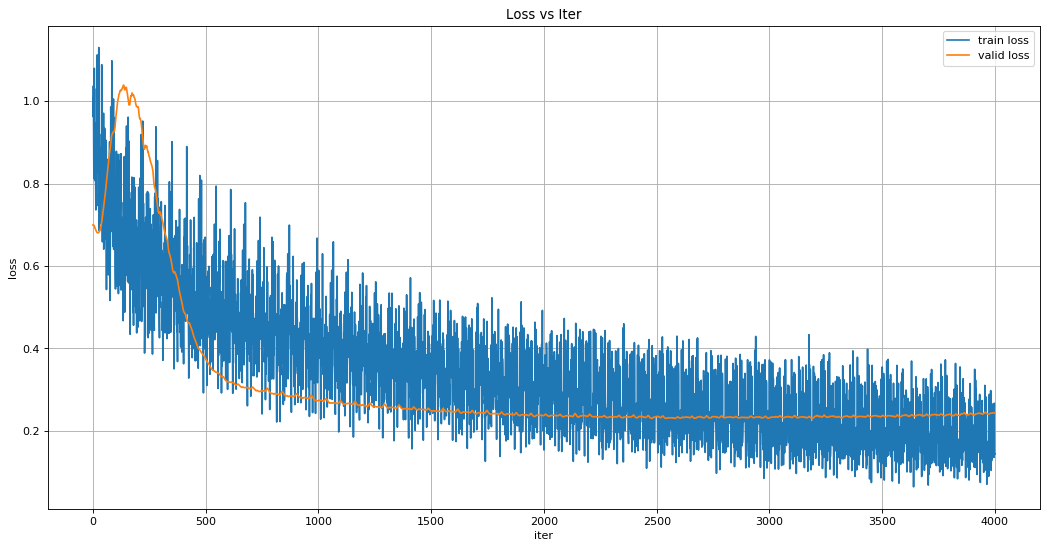

<Figure size 1440x1008 with 0 Axes>

In [82]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(train_loss, label = "train loss")
plt.plot(valid_loss, label = "valid loss")
plt.title("Loss vs Iter")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()
figure_dir = "./model_cost_figures/"
figure_name = "loss_vs_iter"
plt.savefig(figure_dir + figure_name+'.png', bbox_inches='tight')

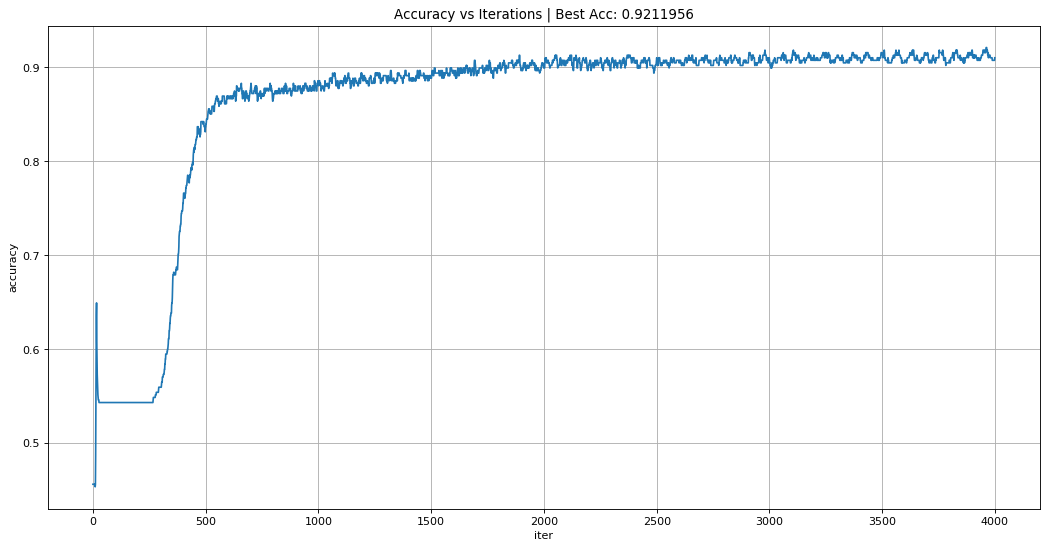

<Figure size 1440x1008 with 0 Axes>

In [83]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(valid_acc,)
plt.title("Accuracy vs Iterations | "+"Best Acc: "+str(best_accuracy))
plt.xlabel("iter")
plt.ylabel("accuracy")
plt.grid()
plt.show()
figure_dir = "./model_cost_figures/"
figure_name = "acc_vs_iter"
plt.savefig(figure_dir + figure_name+'.png', bbox_inches='tight')

In [84]:
submission_dir = "./submission_files/"
submission_file = "submission"
create_submission(saver, test_ids, image_test, angles_test, best_iteration,
                  model_dir, model_name, submission_dir, submission_file,
                  X, Y_pred,angle,keep_prob, training)

INFO:tensorflow:Restoring parameters from ./model_files/model-3962


In [85]:
submision = pd.read_csv(submission_dir+submission_file+".csv")
submision.head(50)

,id,is_iceberg
0,5941774d,1.306646e-23
1,4023181e,5.204683e-08
2,b20200e4,1.129045e-11
3,e7f018bb,7.504482e-20
4,4371c8c3,2.011522e-13
5,a8d9b1fd,2.482495e-14
6,29e7727e,2.257912e-25
7,92a51ffb,1.583511e-22
8,c769ac97,8.616162e-32
9,aee0547d,1.348873e-32
